<a href="https://colab.research.google.com/github/malaireumarianna/NLP/blob/main/Simulated_Annealing_tsp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### <u>**Loading Modules**</u>

In [58]:
!pip install utm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [59]:
import numpy as np
import pandas as pd
from math import radians, cos, sin, asin, sqrt, exp
import random
from matplotlib import pyplot as plt
import networkx as nx
import utm

In [60]:
!git clone https://github.com/malaireumarianna/NLP.git

fatal: destination path 'NLP' already exists and is not an empty directory.


### <u>**Preparing data**</u>

In [61]:
def read_locations(filename):
    locations = []
    with open(filename) as f:
        for l in f.readlines():
            tokens = l.split(' ')
            locations.append((float(tokens[0]), float(tokens[1])))
    return locations

locations = read_locations('/content/NLP/tsp_std.in')
df = pd.DataFrame(locations, columns=['Longitude (in degrees)', 'Latitude (in degrees)'])
df.insert(loc=0, column='Cities', value=np.arange(len(df)))
df

,Cities,Longitude (in degrees),Latitude (in degrees)
0,0,-12.194686,122.467578
1,1,36.646774,101.915720
2,2,-37.221449,148.193049
3,3,32.442924,-59.319808
4,4,6.196574,-80.001104
...,...,...,...
95,95,49.045257,27.709600
96,96,14.940740,89.211347
97,97,29.709701,-167.248474
98,98,58.293676,119.965875


### <u>**Graph Representation**</u>

We used matrix representation. <br>
Entry(i,j) = distance b/w node i and node j.

### <u>**Coding Uitility Functions**</u>

In [62]:
# Haversine formula
def dist_formula(lt1,lg1,lt2,lg2):
    lg1 = radians(lg1)
    lg2 = radians(lg2)
    lt1 = radians(lt1)
    lt2 = radians(lt2)
    dlg = lg2 - lg1
    dlt = lt2 - lt1
    a = sin(dlt / 2)**2 + cos(lt1) * cos(lt2) * sin(dlg / 2)**2
 
    c = 2 * asin(sqrt(a))
    
    # Radius of earth in kilometers. Use 3956 for miles
    r = 6371
      
    # calculate the result
    return(c * r)

In [63]:
def tour_cost(path, distance_matrix):
    dis =0
    for i in range(99):
        ls = [path[i], path[i+1]]
        ls.sort()
        dis += distance_matrix[ls[0]][ls[1]]
    ls = [path[99], path[0]]
    ls.sort()
    dis += distance_matrix[ls[0]][ls[1]]
    return dis

### <u>**Creating Graph**</u>

In [64]:
distance_matrix = np.zeros((100,100)) # distace_matrix[i][j] = distance b/w location i and location j
for i in range(100):
    for j in range(i+1,100):
        distance_matrix[i][j]=dist_formula(df.iloc[i,1],df.iloc[i,2],df.iloc[j,1],df.iloc[j,2])
        distance_matrix[j][i]=distance_matrix[i][j]

In [65]:
G = nx.Graph()
pos = {}
for i in range(100):
    G.add_node(df.iloc[i][0])
    x, y, zone, ut = utm.from_latlon(df.iloc[i][1], df.iloc[i][2])
    pos[df.iloc[i][0]] = (x,y) 
    #G.add_edge(x, y) 

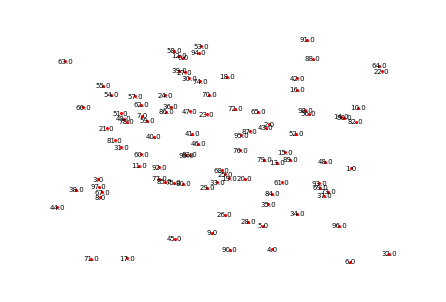

In [66]:
nx.draw(G,pos=pos,with_labels=True, node_color="red", node_size=4, font_size=7)
plt.margins(0.15)
plt.show()

##### *I hid this cell intentionally*

In [67]:
intermediate_costs =[] # y-axis
x=0 # counter for number of actual iterations happened
intermediate_tempr = []

### **<u>Simulated Annealing</u>**

In [87]:
def SA(initial_path, Tm=100000, iter_max=300000, cooling_factor=0.999):
    path = initial_path.copy()
    cost = tour_cost(path=path,distance_matrix=distance_matrix)

    global intermediate_costs
    intermediate_costs.append(cost)
    global intermediate_tempr
    intermediate_tempr.append(Tm)

    for i in range(1,iter_max):
        two_indices = random.sample(range(100),2)
        # two_indices.sort()
        next_path = path.copy()
        next_path[two_indices[0]:two_indices[1]+1] = next_path[two_indices[0]:two_indices[1]+1][::-1] # reverse sublist
        next_cost = tour_cost(next_path,distance_matrix=distance_matrix)

        dE = cost - next_cost # delta Energy

        T = Tm*(cooling_factor**i)
        # T = Tm*(cooling_factor/i)

        if(T == 1e-6):
            break

        try:
            pb = 1/(1+exp(-dE/T))
        except: 
            continue
        if dE > 0:
            path = next_path.copy()
        else:
            if  random.random() < pb:
                path = next_path.copy()
        cost = tour_cost(path,distance_matrix=distance_matrix)

        intermediate_costs.append(next_cost)
        intermediate_tempr.append(T)
        global x
        x += 1
        
    final_cost = cost
    final_path = path.copy()
    return final_path

### <u>**Setting Initial Path Randomly**</u>

In [88]:
init_path = np.random.permutation(100) # initial solution
print(init_path)

[26 91 79 27  3 34 81 19 44 97 98 75  0 54 51 13 49  7 66 55 85 76 11 63
 50  9 17 14 60 99 42 18 77 15 30 25 89 12 10 61 37  8 96 72 69 45 32 71
 28 16 53 80 94 48 46 35 29 62 83 93 20 73 24 58 67 92 21 43 86 52 90 82
 36 56 23 70 87 33 68  5 65 47  4 78 31 88 84 57 59 38 95  6 39  1 22 41
 40 64  2 74]


In [89]:
cost = tour_cost(init_path,distance_matrix=distance_matrix)
initial_cost = cost
print("Initial Cost: ",initial_cost)

Initial Cost:  1026688.8344066765


In [90]:
final_path = SA(init_path)
final_cost = tour_cost(final_path,distance_matrix=distance_matrix)
print("Final Cost: ",final_cost)

Final Cost:  179429.43584416257


In [91]:
initial_graph = G.copy()
for i in range(99):
    initial_graph.add_edge(df.iloc[init_path[i]][0],df.iloc[init_path[i+1]][0])
initial_graph.add_edge(df.iloc[init_path[19]][0],df.iloc[init_path[0]][0])

final_graph = G.copy()
for i in range(99):
    final_graph.add_edge(df.iloc[final_path[i]][0],df.iloc[final_path[i+1]][0])
final_graph.add_edge(df.iloc[final_path[19]][0],df.iloc[final_path[0]][0])

Initial Cost:  1026688.8344066765  km


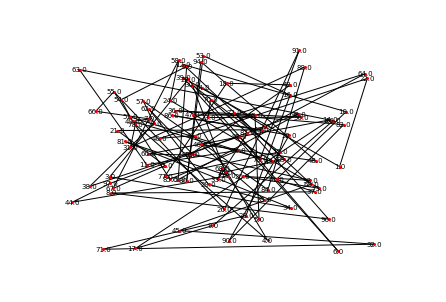

In [92]:
print("Initial Cost: ", initial_cost, " km")
nx.draw(initial_graph,pos=pos,with_labels=True, node_color="red", node_size=4, font_size=7)
plt.margins(0.15)
plt.show()

Final Cost:  179429.43584416257  km


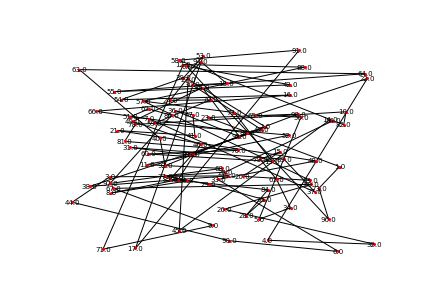

In [93]:
print("Final Cost: ", final_cost, " km")
nx.draw(final_graph,pos=pos,with_labels=True, node_color="red", node_size=4, font_size=7)
plt.margins(0.15)
plt.show()

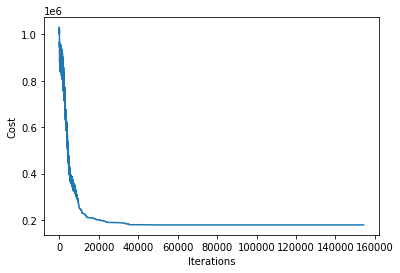

In [94]:
global intermediate_costs
intermediate_costs = []
global x
x = 0
SA(initial_path=init_path)
plt.plot(range(x+1),intermediate_costs)
plt.title("")
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.show()